![Py4Eng](img/logo.png)

# Differential equations
## Yoav Ram

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from scipy.integrate import solve_ivp, odeint
import seaborn as sns
sns.set(
    style='white',
    context='notebook',
    font_scale=1.5
)
from ipywidgets import interact # not a must, but can install with conda install -c conda-forge ipywidgets

# Deterministic differential equations

## Predator-prey model

The predator-prey model is summarized by these ordinary differential equations (ODE):

$$
\frac{dx}{dt} = b x - h x y \\
\frac{dy}{dt} = \epsilon h x y - d y
$$

where the parameters are:
- $x$ is the density of the *prey* (hare, gnu, mouse)
- $y$ is the density of the *predator* (lynx, lion, owl)
- $b$ is the *prey* birth rate
- $d$ is the *predator* death rate
- $h$ is the rate at which, when *predator* and *prey* meet, predation occurs
- $\epsilon$ is the rate at which *prey* density is converted to *predator* density when predation occurs

To implement the model we first write the ODE as a function:

In [8]:
def ode(t, xy, b, h, ϵ, d):
    x, y = xy
    dx = b * x - h * x * y
    dy = ϵ * h * x * y - d * y
    return np.array((dx, dy))

## Integration

Now let's integrate the ODE.


### Hand-made integration

First let's implement an integration method of our own by making a discrete linear approximation of the ODE:

$$
x_{t} = x_{t-1} + \frac{d x}{d t} \cdot dt \\
y_{t} = y_{t-1} + \frac{d y}{d t} \cdot dt
$$

In [42]:
# model parameters
b = 1
h = 0.005
ϵ = 0.8
d = 0.6

steps = 100000 # number integration steps
xy = np.empty((2, steps)) # population array
xy[:,0] = 50, 100 # initial population sizes
dt = 0.001 # time step for integration

for t in range(1, steps):
    xy[:, t] = xy[:, t-1] + ode(t, xy[:, t-1], b, h, ϵ, d) * dt

x = xy[0, :]
y = xy[1, :]
t = np.arange(0, dt * steps, dt)

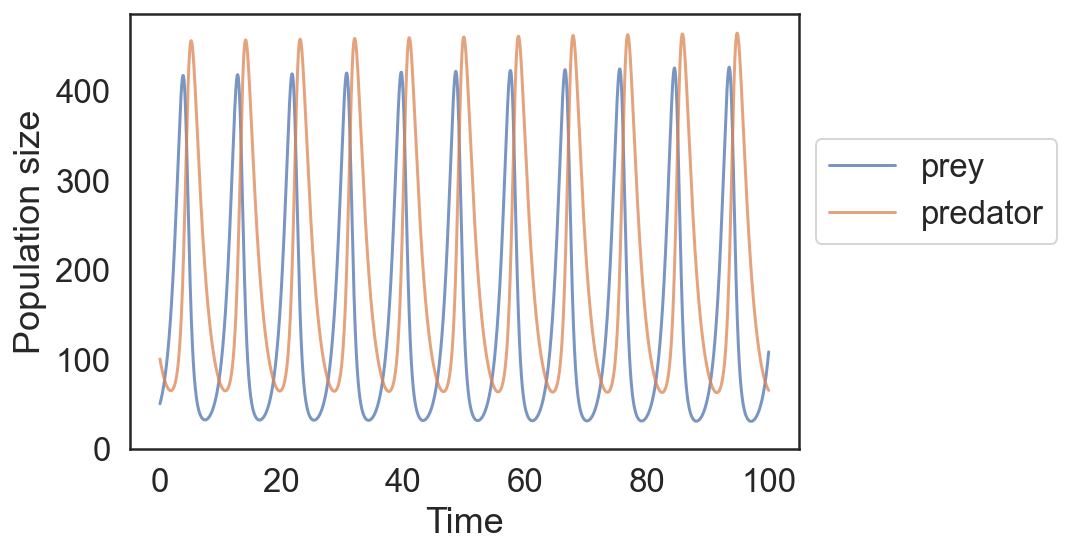

In [43]:
plt.plot(t, x, alpha=0.75, label='prey')
plt.plot(t, y, alpha=0.75, label='predator')

plt.xlabel('Time')
plt.ylabel('Population size')
plt.ylim(0, None)
# bbox_to_anchor places the legend at specific position, in this case outside the plo
plt.legend(bbox_to_anchor=(1, 0.75))

We can see the cycles: more prey = more food for predators = more predators = less prey = less food for predators = less predators = more prey ...

Another way to visualize the dynamics as *orbits* in phase space.

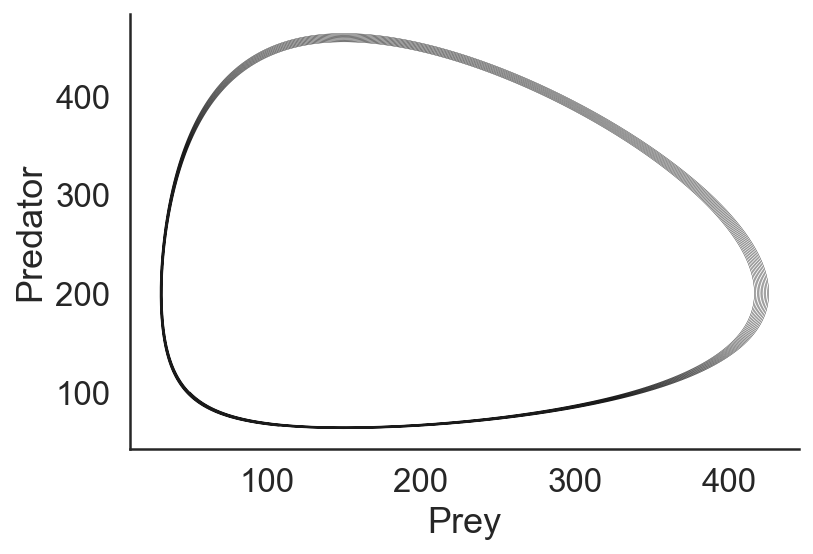

In [44]:
plt.plot(x, y, linewidth=0.2, color='k')
plt.xlabel('Prey')
plt.ylabel('Predator')
sns.despine()

### Integration with SciPy

We are better off using one of SciPy's [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) function, which automatically choses `dt` and `steps` to make sure `dx` and `dy` are small so that the linearization is effective.

Note: `solve_inp` is relateively new, the previous solver (which you can still use) is called `odeint`.

Some of the solvers require the Jacobian, or the matrix of 2nd order parital derivatives:

$$
\mathbf{J}(x, y) = 
\pmatrix{
    \frac{\partial^2 x}{\partial t \partial x} & \frac{\partial^2 x}{\partial t \partial y} \\
    \frac{\partial^2 y}{\partial t \partial x} & \frac{\partial^2 y}{\partial t \partial y}
} = 
\pmatrix{
    b - h y & -h x \\
    \epsilon h y & \epsilon h x - d
}
$$

In [45]:
def jac(t, xy, b, h, ϵ, d):
    x, y = xy
    return np.array([
        [b - h * y,     -h * x],
        [ϵ * h * y,     ϵ * h * x - d]
    ])

We make a partial version of the `ode` and of `jac` which has the model parameters fixed, and use `solve_ivp` with the BDF solver (_backward differentiation formula_).

We plot the dynamics plots.
We also add quivers to the phase plot to anotate the direction of the dynamics.

In [56]:
t = np.linspace(0, 50, 50*10)
xy0 = (50, 100)
params = (b, h, ϵ, d)
sol = solve_ivp(ode, (t.min(), t.max()), xy0, t_eval=t, 
                method='BDF', jac=jac, args=params)
assert sol.success
x, y = sol.y

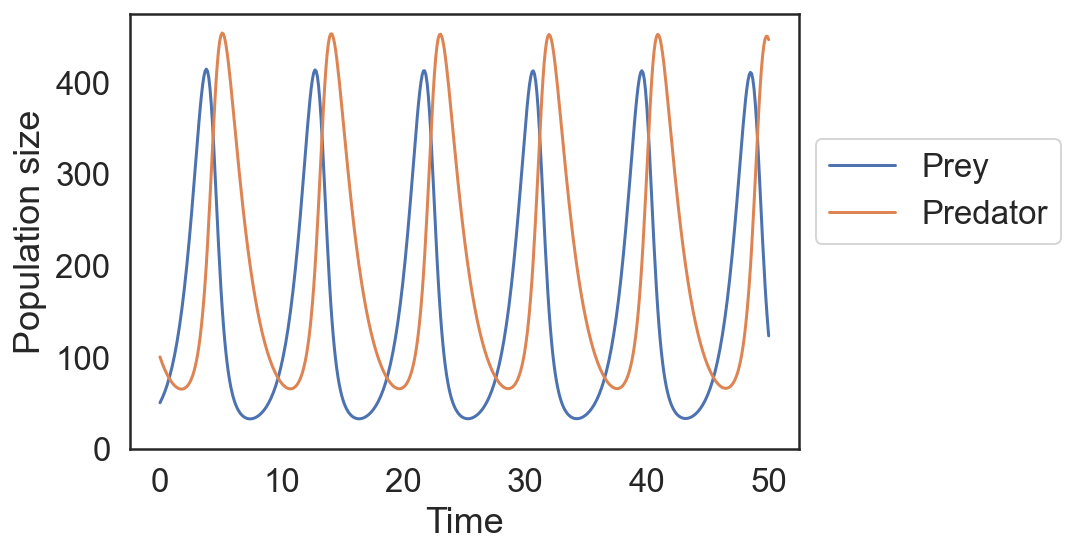

In [57]:
plt.plot(t, x, label='Prey')
plt.plot(t, y, label='Predator')
plt.xlabel('Time')
plt.ylabel('Population size') 
plt.ylim(0, None)
plt.legend(bbox_to_anchor=(1, 0.75));

We'll also do a quiver plots that shows the dynamics in the phase plane.

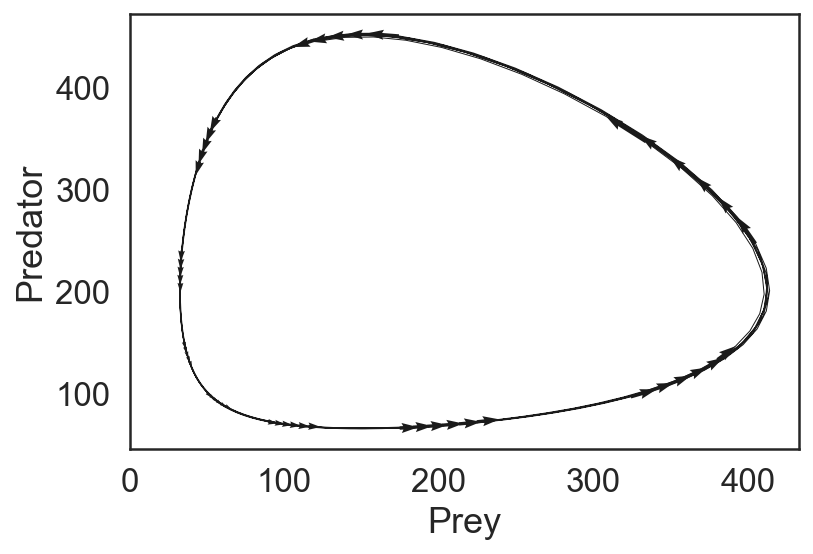

In [58]:
q_dt = 10
plt.plot(x, y, lw=0.5, color='k')
plt.quiver(x[:-1:q_dt], y[:-1:q_dt], 
           x[1::q_dt] - x[:-1:q_dt], 
           y[1::q_dt] - y[:-1:q_dt], 
           scale_units='xy', angles='xy', scale=1, width=0.005)
plt.xlabel('Prey')
plt.ylabel('Predator')
plt.xlim(0, None);

**Note** this is an example where the `method` of the ODE solver is important - change the method and you don't get a cycle due to numerical errors.

The plots look similar, except that maybe the phase plot is more tight. 
We immediately see that we have a cycle, which seems stable!

Let's wrap this in a function that also plots the dynamics so that we can easily reuse it later.

In [65]:
def solve_plot(x0, y0, tmax, b, h, ϵ, d):
    t = np.linspace(0, tmax, tmax*10)
    xy0 = (x0, y0)
    params = (b, h, ϵ, d)
    sol = solve_ivp(ode, (t.min(), t.max()), xy0, t_eval=t, 
                method='BDF', jac=jac, args=params)
    x, y = sol.y
    plt.plot(t, x, label='Prey')
    plt.plot(t, y, label='Predator')
    plt.xlabel('Time')
    plt.ylabel('Population size') 
    plt.ylim(0, None)
    plt.legend(bbox_to_anchor=(1, 0.75))
    plt.show()

In [64]:
b,h,ϵ,d

(1, 0.005, 0.8, 0.6)

We can explore the dynamics for different values using `interact` from the [ipywidgets](https://github.com/ipython/ipywidgets) pakcage - try to check if the cycle is stable for other choice of parameters.

Install it with `conda install ipywidgets` or `pip install ipywidgets`.

In [67]:
interact(solve_plot,
        x0=(1, 100, 1), y0=(1, 100, 1), tmax=(1, 1001, 10), 
        b=(0, 2, 0.1), h=(0, 0.1, 0.001), ϵ=(0.01, 1, 0.01), d=(0, 2, 0.1));

interactive(children=(IntSlider(value=50, description='x0', min=1), IntSlider(value=50, description='y0', min=…

## Coupled spring-mass system

![Springs figure](https://scipy.github.io/old-wiki/pages/Cookbook/two_springs_diagramd4f6.png?action=AttachFile&do=get&target=two_springs_diagram.png)

Two objects with masses $m_1$ and $m_2$ and displacement $x_1$ and $x_2$ are coupled through springs with spring constants $k_1$ and $k_2$. The left end of the left spring is fixed. We assume that the lengths of the springs, when subjected to no external forces, are $L_1$ and $L_2$.

The masses are sliding on a surface that creates friction, so there are two friction coefficients, $b_1$ and $b_2$. 

The deterministic differential equations are:

$$
m_1 x_1'' = - b_1 x_1' - k_1 (x_1 - L_1) + k_2 (x_2 - x_1 - L_2) \\
m_2 x_2'' = - b_2 x_2' - k_2 (x_2 - x_1 - L_2) 
$$

This is a pair of coupled second order equations. To solve this system with one of the ODE solvers provided by *SciPy*, we must first convert this to a system of first order differential equations. We introduce two variables

$$
y_1 = x_1' \\
y_2 = x_2'
$$

These are the velocities of the masses. 

With a little algebra, we can rewrite the two second order equations as the following system of four first order equations:

$$
x_1' = y_1 \\
y_1' = (-b_1 y_1 - k_1 (x_1 - L_1) + k_2 (x_2 - x_1 - L_2))/ m_1 \\
x_2' = y_2 \\
y_2' = (-b_2 y_2 - k_2 (x_2 - x_1 - L_2)) / m_2
$$

These equations are now in a form that we can implement in Python.

The following code defines the "right hand side" of the system of equations (also known as a vector field). Note that the arguments of the function `vectorfield` are configured to be used with the `odeint` function: the dependent variable is first (`w=(x_1, y_1, x_2, y_2)`), the independent varialbe (i.e. time, `t`) is the second argument, the problem parameters follow.

**Note** `odeint` is the old API, it is preferable to use `solve_ivp`.

In [70]:
def ode(v, t, *params):
    """Defines the differential equations for the coupled spring-mass system.

    Arguments
    ---------
     v :  np.ndarray
         vector of the state variables: v = [x1, y1, x2, y2]
     t :  float
         time
     params :  tuple 
         problem parameters: params = (m1, m2, k1, k2, L1, L2, b1, b2) 
    """
    x1, y1, x2, y2 = v
    m1, m2, k1, k2, L1, L2, b1, b2 = params

    dx1 = y1
    dy1 = (-b1 * y1 - k1 * (x1 - L1) + k2 * (x2 - x1 - L2)) / m1
    dx2 = y2
    dy2 = (-b2 * y2 - k2 * (x2 - x1 - L2)) / m2
    return dx1, dy1, dx2, dy2    

In [82]:
# Parameter values
# Masses:
m1 = 1.0
m2 = 1.5
# Spring constants
k1 = 8.0
k2 = 40.0
# Natural lengths
L1 = 0.5
L2 = 1.0
# Friction coefficients
b1 = 0.8
b2 = 0.5

# Initial conditions
# x1 and x2 are the initial displacements; y1 and y2 are the initial velocities
x1 = 0.5
y1 = 0.0
x2 = 2.25
y2 = 0.0
v0 = x1, y1, x2, y2

# Create the time samples for the output of the ODE solver
t = np.linspace(0, 15, 1000)
params = (m1, m2, k1, k2, L1, L2, b1, b2)

# Solve
v = odeint(ode, v0, t, args=params)
x1, y1, x2, y2 = v.T

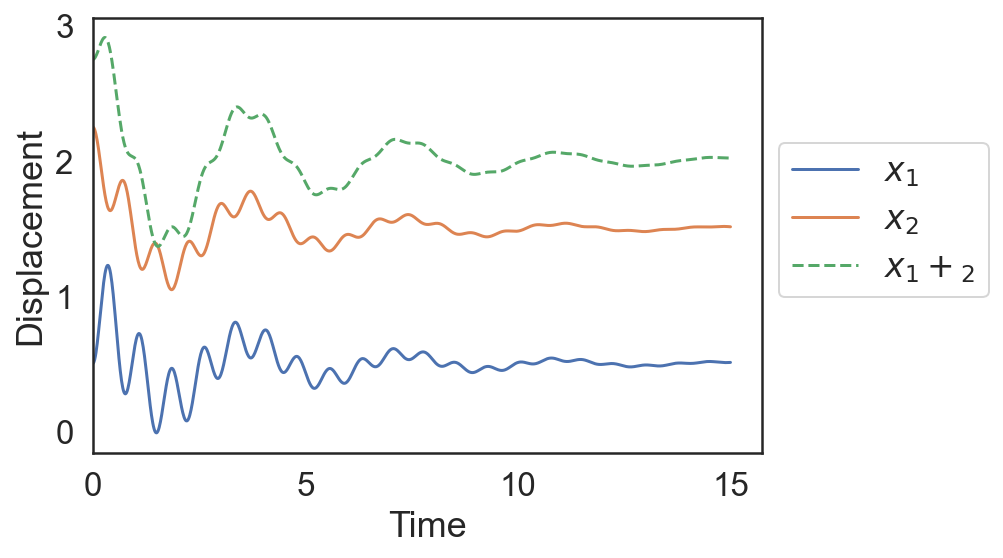

In [87]:
plt.plot(t, x1, label=r'$x_1$')
plt.plot(t, x2, label=r'$x_2$')
plt.plot(t, x1+x2, '--', label=r'$x_1+_2$')
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.xlim(0, None)
plt.legend(bbox_to_anchor=(1, 0.75));

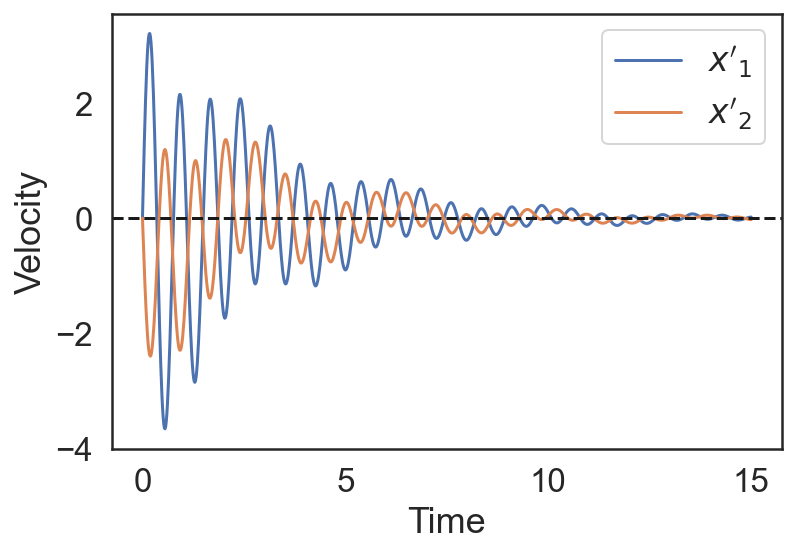

In [88]:
plt.plot(t, y1, label=r"$x'_1$")
plt.plot(t, y2, label=r"$x'_2$")
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.axhline(0, color='k', ls='--')
plt.legend();

Text(0, 0.5, '$x_2$')

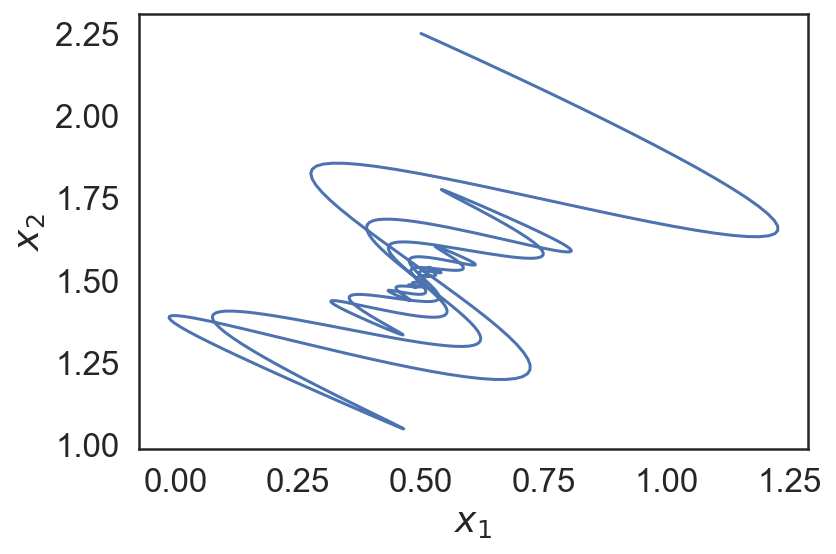

In [89]:
plt.plot(x1, x2)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

To really explore the solution, we can use the `interact` decorator from the [ipywidgets](https://github.com/ipython/ipywidgets) pakcage. This will add sliders to control the problem parameters, which will allow us to easily explore how the solutions look.

In [91]:
@interact(x1=(0.0, 3.0), y1 = (-1.0, 1.0), x2 = (0.0, 3.0), y2 = (-1.0, 1.0), maxt=10.0)
def springs(x1, y1, x2, y2, maxt):    
    v0 = (x1, y1, x2, y2)
    t = np.linspace(0, maxt, 250)
    params = (m1, m2, k1, k2, L1, L2, b1, b2)
    v = odeint(ode, v0, t, args=params)
    x1, _, x2, _ = v.T
    plt.plot(t, x1, label=r'$x_1$')
    plt.plot(t, x2, label=r'$x_2$')
    plt.xlabel('Time')
    plt.ylabel('Displacement')
    plt.legend()
    plt.show()

interactive(children=(FloatSlider(value=1.5, description='x1', max=3.0), FloatSlider(value=0.0, description='y…

## Exercise

Integrate the [Lorentz' system](https://en.wikipedia.org/wiki/Lorenz_system):
$$
\frac{dx}{dt} = \alpha ( y - x) \\
\frac{dy}{dt} = x ( \rho - z) -y \\
\frac{dz}{dt} = xy - \beta z
$$

Plot a solution with four figure panels: 
- x(t), y(t), z(t)
- y(x)
- z(y)
- z(x)

See [solution code](../solutions/lorentz.ipynb).

In [94]:
α = 10
ρ = 28
β = 8/3

def ode(v, t, α, ρ, β):
    x, y, z = v
    return np.array([
        # your code here
    
    ])

t = np.linspace(0, 20, 2000)
x, y, z = odeint(ode, (0.1, 0.1, 0.1), t, args=(α, ρ, β)).T

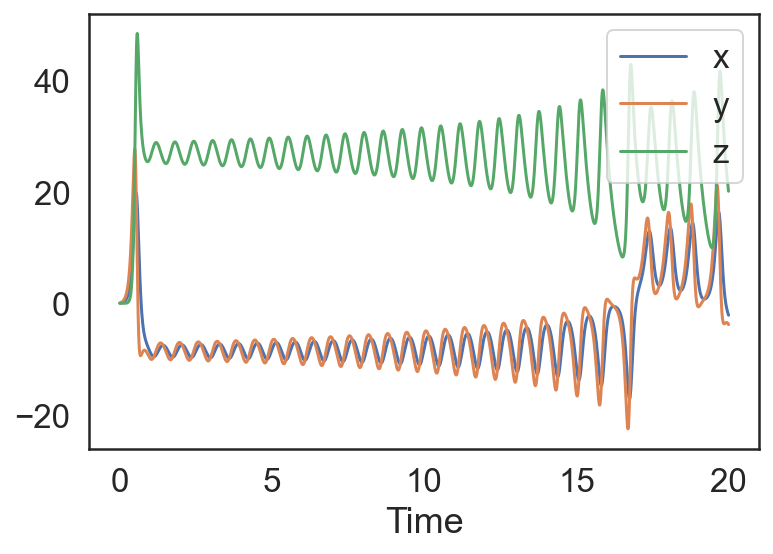

In [97]:
plt.plot(t, x, label='x')
plt.plot(t, y, label='y')
plt.plot(t, z, label='z')
plt.legend()
plt.xlabel('Time');

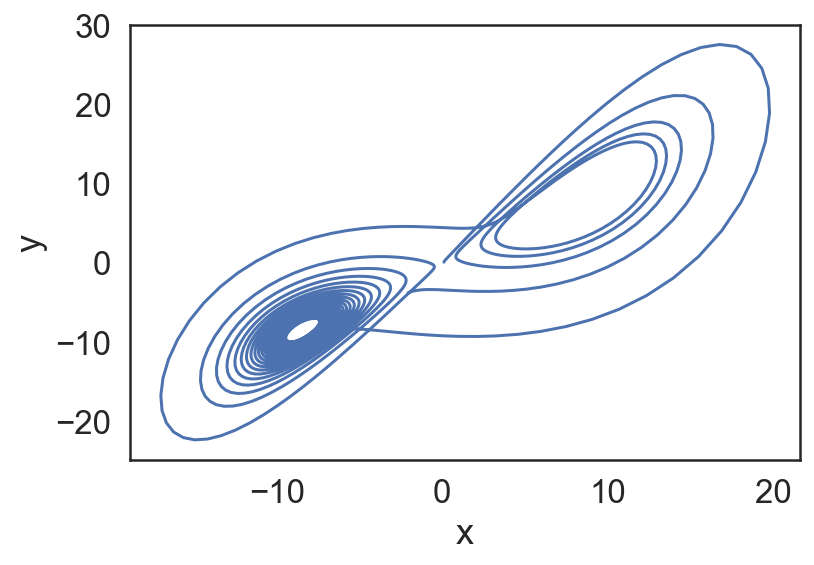

In [98]:
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y');

# Stochastic differential equations

Stochastic differential equations or SDE are differential equations are used to model systems with both a deterministic influence and a random influence. The simplest example is the motion of a massive Brownian particle under the influence of friction ([Ornstein–Uhlenbeck process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)). 

We will use the [sdeint](https://github.com/mattja/sdeint) solver. Install it with `pip install sdeint` (version 0.2.0 may have trouble installing, get version 0.2.1).

In [102]:
import sdeint
print("sdeint version:", sdeint.__version__)

sdeint version: 0.2.2


## Stochastic spring fluctuation

Consider a spring with a contant $k$ moving under friction with coefficient $\gamma$ in the presence of thermal fluctuations with temperature $T$. The length of the spring $y(t)$ will fluctuate stochastically around the spring rest length $y^*$ and its dynamics can be described by an Ito equation:

$$
dy = f(y,t)dt + G(y,t) dW
$$

where $f(y,t) = \theta (y^* - y)$, $G = \sqrt{2 D}$, $\theta=k/\gamma$ and $D$ is the effective diffusion constant ($D=k_B T  / \gamma$).

In [103]:
help(sdeint.itoint)

Help on function itoint in module sdeint.integrate:

itoint(f, G, y0, tspan)
    Numerically integrate the Ito equation  dy = f(y,t)dt + G(y,t)dW
    
    where y is the d-dimensional state vector, f is a vector-valued function,
    G is an d x m matrix-valued function giving the noise coefficients and
    dW(t) = (dW_1, dW_2, ... dW_m) is a vector of independent Wiener increments
    
    Args:
      f: callable(y,t) returning a numpy array of shape (d,)
         Vector-valued function to define the deterministic part of the system
      G: callable(y,t) returning a numpy array of shape (d,m)
         Matrix-valued function to define the noise coefficients of the system
      y0: array of shape (d,) giving the initial state vector y(t==0)
      tspan (array): The sequence of time points for which to solve for y.
        These must be equally spaced, e.g. np.arange(0,10,0.005)
        tspan[0] is the intial time corresponding to the initial state y0.
    
    Returns:
      y: array, w

In [104]:
θ = 1.0
ystar = 1.0
D = 0.045

In [105]:
def f(y, t): 
    return θ * (ystar - y)

def G(y, t): 
    return np.sqrt(2 * D)

y0 = 1.2
t = np.linspace(0, 20, 1000)

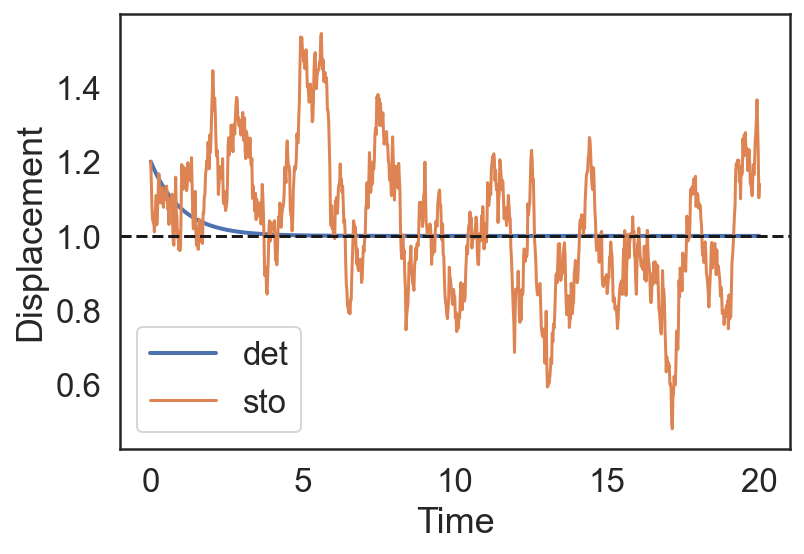

In [109]:
y_det = odeint(f, y0, t)
y_sto = sdeint.itoint(f, G, y0, t)
plt.plot(t, y_det, lw=2, label='det')
plt.plot(t, y_sto, label='sto')
plt.axhline(ystar, ls='--', color='k')
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.legend();

Let's plot 5 solutions of the SDE - 5 independent springs - and add some widgets so that we can control the problem parameters:

In [125]:
@interact(θ=(0, 2), y0=(0, 2), ystar=(0, 2), logD=(-3.0, 0), maxt=(0, 50, 20))
def stoch_dynamics(θ, y0, ystar, logD, maxt):
    D = np.exp(logD)
    f = lambda y, t: θ * (ystar - y)
    G = lambda y, t: np.sqrt(2 * D)
    t = np.linspace(0, maxt, 1000)
    y_sto = [sdeint.itoint(f, G, y0, t).ravel() for i in range(5)]
    y_sto = np.array(y_sto).T
    y_det = odeint(f, y0, t)
    
    plt.plot(t, y_sto, alpha=0.6)
    plt.plot(t, y_det, color='k', lw=2)
    plt.axhline(ystar, ls='--', color='k')
    plt.xlabel('Time')
    plt.ylabel('Displacement')
    plt.show()

interactive(children=(IntSlider(value=1, description='θ', max=2), IntSlider(value=1, description='y0', max=2),…

# References

- [A coupled spring-mass system](https://scipy.github.io/old-wiki/pages/Cookbook/CoupledSpringMassSystem.html) / The SciPy Cookbook
- [Ornstein–Uhlenbeck process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process#Application_in_physical_sciences) / Wikipedia
- [Stochastic differential equations](http://www.azimuthproject.org/azimuth/show/Stochastic+differential+equation) / Azimuth project
- [sdeint](https://github.com/mattja/sdeint): Numerical integration of Ito or Stratonovich SDEs.
- [ipywidgets](https://github.com/ipython/ipywidgets): the notebook widgets

## Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Python for Engineers_](https://github.com/yoavram/Py4Eng) course.

The notebook was written using [Python](http://python.org/) 3.6.1.
Dependencies listed in [environment.yml](../environment.yml), full versions in [environment_full.yml](../environment_full.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)